In [75]:
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import shap 
import time
import seaborn as sns

sns.set()


sns.set_theme(style="ticks", color_codes=True)

%matplotlib inline


In [2]:
df_base = pd.read_csv('airbnb_clean.csv').set_index("id")
df_ammenities = pd.read_csv('airbnb_amenities_clean.csv').set_index("id")
df = pd.concat([df_base, df_ammenities], axis=1)


# Modificación del dataset 

## Cambio de valores string y booleanos por enteros en las columnas categoricas

In [3]:
# Se quita host_sice ya que no es necesario para el modelo propuesto
Y = df['log_price']
df.drop(columns=["log_price", 'host_since'], inplace=True)
#df.drop(columns=["log_price", 'host_since', 'host_has_profile_pic', 'longitude'], inplace=True)

In [4]:
bool_columns=df.select_dtypes(include = "bool").columns
string_columns=df.select_dtypes(include = "object").columns.tolist()

df[bool_columns]= df[bool_columns].replace({True: 1, False: 0})

#Se reemplazan los valores categoricos de string por valores numericos categoricos
#Se guardan las llaves y valores en dict_column_dict

dict_column_dict=[]
for column in string_columns:
    column_unique_value=df[column].unique().tolist()
    column_dictionary={column_unique_value[i]:i for i in range(0, len(column_unique_value))}
    dict_column_dict.append(column_dictionary)
    df[column]=df[column].replace(column_dictionary)


In [5]:
df.head()

,property_type,room_type,accommodates,bathrooms,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,...,First_aid_kit,Cable_TV,Free_parking_on_premises,24_hour_check_in,Lock_on_bedroom_door,Buzzer_wireless_intercom,Safety_card,Self_Check_In,Elevator,Pets_allowed
id,,,,,,,,,,,,,,,,,,,,,
6901257,0,0,3,1.0,1,0,1,1,0,40.696524,...,0,0,0,0,0,0,0,0,0,0
6304928,0,0,7,1.0,1,0,1,0,1,40.766115,...,0,0,0,0,0,0,0,0,0,0
7919400,0,0,5,1.0,1,0,1,1,1,40.808110,...,0,1,0,0,0,1,0,0,0,0
13418779,1,0,4,1.0,1,1,1,1,0,37.772004,...,1,1,0,0,0,1,0,0,0,0
3808709,0,0,2,1.0,1,2,1,1,1,38.925627,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering

## Eliminar las columnas con zero y poca varianza

In [6]:
df.nunique()

property_type                   35
room_type                        3
accommodates                    16
bathrooms                       17
cleaning_fee                     2
city                             6
host_has_profile_pic             2
host_identity_verified           2
instant_bookable                 2
latitude                     72830
longitude                    72830
number_of_reviews              371
review_scores_rating            55
zipcode                        647
bedrooms                        11
beds                            17
Wireless_Internet                2
Kitchen                          2
Heating                          2
Essentials                       2
Smoke_detector                   2
Air_conditioning                 2
TV                               2
Shampoo                          2
Hangers                          2
Carbon_monoxide_detector         2
Internet                         2
Laptop_friendly_workspace        2
Hair_dryer          

Eliminar las variables que son 95% o más iguales en todas las instancias

In [7]:

var_thr = VarianceThreshold(threshold = 0.05) #Removing both constant and quasi-constant
var_thr.fit(df)

concol = [column for column in df.columns 
          if column not in df.columns[var_thr.get_support()]]

for features in concol:
    print(features)



host_has_profile_pic
Wireless_Internet


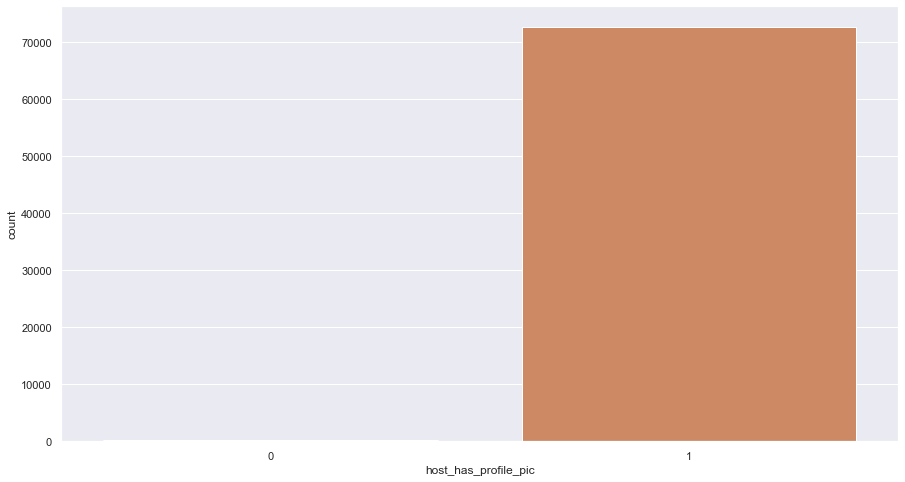

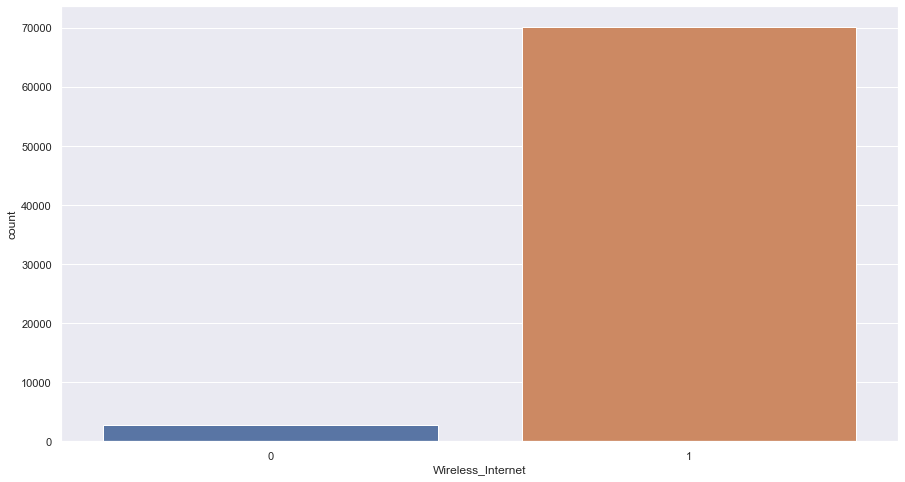

In [8]:
for features in concol:
    sns.set(rc = {'figure.figsize':(15,8)})
    sns.countplot(data=df,x=df[features])
    #plt.ylim(0,3000)
    plt.show()
    len(df[df['accommodates']>15])

In [9]:
df.drop(columns=concol, inplace=True)
df.head()

,property_type,room_type,accommodates,bathrooms,cleaning_fee,city,host_identity_verified,instant_bookable,latitude,longitude,...,First_aid_kit,Cable_TV,Free_parking_on_premises,24_hour_check_in,Lock_on_bedroom_door,Buzzer_wireless_intercom,Safety_card,Self_Check_In,Elevator,Pets_allowed
id,,,,,,,,,,,,,,,,,,,,,
6901257,0,0,3,1.0,1,0,1,0,40.696524,-73.991617,...,0,0,0,0,0,0,0,0,0,0
6304928,0,0,7,1.0,1,0,0,1,40.766115,-73.989040,...,0,0,0,0,0,0,0,0,0,0
7919400,0,0,5,1.0,1,0,1,1,40.808110,-73.943756,...,0,1,0,0,0,1,0,0,0,0
13418779,1,0,4,1.0,1,1,1,0,37.772004,-122.431619,...,1,1,0,0,0,1,0,0,0,0
3808709,0,0,2,1.0,1,2,1,1,38.925627,-77.034596,...,0,0,0,0,0,0,0,0,0,0


## Eliminar las variables con alta correlación

## HeatMap

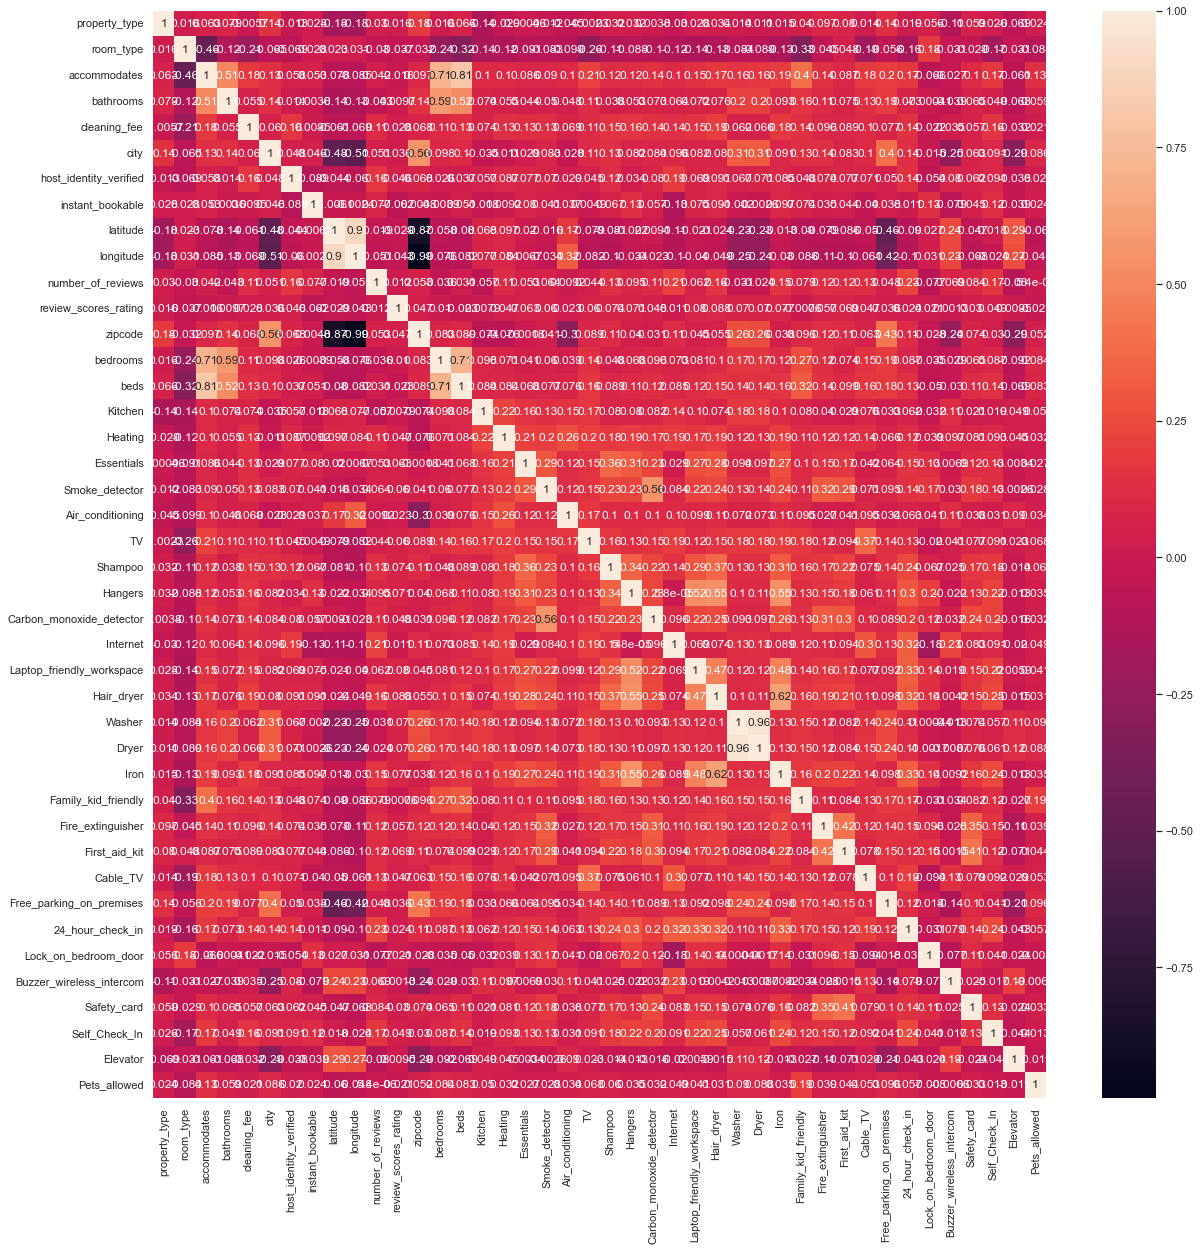

In [10]:
fig, ax = plt.subplots(figsize=(20, 20))
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

In [11]:

df.drop(columns=["Washer", 'latitude'], inplace=True)


# Entrenamiento sin features eliminadas por Heatmap y baja varianza

In [12]:
df.columns

Index(['property_type', 'room_type', 'accommodates', 'bathrooms',
       'cleaning_fee', 'city', 'host_identity_verified', 'instant_bookable',
       'longitude', 'number_of_reviews', 'review_scores_rating', 'zipcode',
       'bedrooms', 'beds', 'Kitchen', 'Heating', 'Essentials',
       'Smoke_detector', 'Air_conditioning', 'TV', 'Shampoo', 'Hangers',
       'Carbon_monoxide_detector', 'Internet', 'Laptop_friendly_workspace',
       'Hair_dryer', 'Dryer', 'Iron', 'Family_kid_friendly',
       'Fire_extinguisher', 'First_aid_kit', 'Cable_TV',
       'Free_parking_on_premises', '24_hour_check_in', 'Lock_on_bedroom_door',
       'Buzzer_wireless_intercom', 'Safety_card', 'Self_Check_In', 'Elevator',
       'Pets_allowed'],
      dtype='object')

## Descomentar la siguiente celda si se quiere entrenar los modelos con estas features

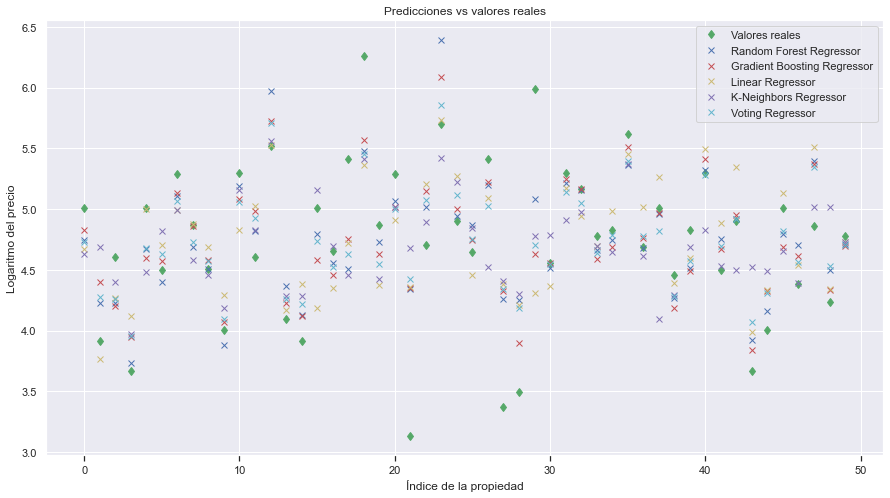

RF_R2 [0.6994524477593684, 0.6982324957414817, 0.698793839732646, 0.6976024093877402, 0.6981629025698697]
 
GB_R2 [0.6819804514911494, 0.6819699428859871, 0.6819699428859872, 0.6819804514911496, 0.6819699428859871]
 
LR_R2 [0.5616186406931413, 0.5616186406931413, 0.5616186406931413, 0.5616186406931413, 0.5616186406931413]
 
KN_R2 [0.4768472421701262, 0.4768472421701262, 0.4768472421701262, 0.4768472421701262, 0.4768472421701262]
 
VR_R2 [0.6779376716943937, 0.6779068362727977, 0.6775611565241156, 0.6779559407987035, 0.678001515029127]


In [13]:

X= df


RF_R2 = []
GB_R2 = []
LR_R2 = []
KN_R2 = []
VR_R2 = []

Mean_squared_errors = []



for i in range (5):

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    random_forest = RandomForestRegressor(n_estimators=100)
    random_forest.fit(X_train, y_train)
    rf_pred = random_forest.predict(X_test)
    rf_score = r2_score(y_test, rf_pred)
    rf_mse = mean_squared_error(y_test, rf_pred)
    #print(f"Random forest     : R2 {rf_score:.5f}  MSE {rf_mse:2.5f}")

    gradient_boosting = GradientBoostingRegressor(n_estimators=150)
    gradient_boosting.fit(X_train, y_train)
    gb_pred = gradient_boosting.predict(X_test)
    gb_score = r2_score(y_test, gb_pred)
    gb_mse = mean_squared_error(y_test, gb_pred)
    #print(f"Gradient boosting : R2 {gb_score:.5f}  MSE {gb_mse:2.5f}")

    linear_reg = LinearRegression(fit_intercept=True)
    linear_reg.fit(X_train, y_train)
    lr_pred = linear_reg.predict(X_test)
    lr_score = r2_score(y_test, lr_pred)
    lr_mse = mean_squared_error(y_test, lr_pred)
    #print(f"Linear regression : R2 {lr_score:.5f}  MSE {lr_mse:2.5f}")

    k_neighbors = KNeighborsRegressor(n_neighbors=30)
    k_neighbors.fit(X_train, y_train)
    kn_pred = k_neighbors.predict(X_test)
    kn_score = r2_score(y_test, kn_pred)
    kn_mse = mean_squared_error(y_test, kn_pred)
    #print(f"K Neighbors       : R2 {kn_score:.5f}  MSE {kn_mse:2.5f}")

    voting_reg = VotingRegressor(
        [("RF", random_forest), ("GB", gradient_boosting), ("KN", k_neighbors), ("LN", linear_reg)])
    voting_reg.fit(X_train, y_train)
    vr_pred = voting_reg.predict(X_test)
    vr_score = r2_score(y_test, vr_pred)
    vr_mse = mean_squared_error(y_test, vr_pred)
    #print(f"Voting regressor  : R2 {vr_score:.5f}  MSE {vr_mse:2.5f}")

    RF_R2.append(rf_score)
    GB_R2.append(gb_score)
    LR_R2.append(lr_score)
    KN_R2.append(kn_score)
    VR_R2.append(vr_score)


np.savetxt("Puntuaciones_RandomForestRegressor.csv", RF_R2, delimiter = ',')
np.savetxt("Puntuaciones_GradientBoostingRegressor.csv", GB_R2, delimiter = ',')
np.savetxt("Puntuaciones_LinearRegressor.csv", LR_R2, delimiter = ',')
np.savetxt("Puntuaciones_KNNRegressor.csv", KN_R2, delimiter = ',')
np.savetxt("Puntuaciones_VotingRegressor.csv", VR_R2, delimiter = ',')

rf_pred_col = rf_pred.reshape(-1, 1)
gb_pred_col = gb_pred.reshape(-1, 1)
kn_pred_col = kn_pred.reshape(-1, 1)
lr_pred_col = lr_pred.reshape(-1, 1)
vr_pred_col = vr_pred.reshape(-1, 1)
y_test_col = y_test.values.reshape(-1, 1)

plt.figure()
plt.plot(y_test_col[0:50, :], "gd", label="Valores reales")
plt.plot(rf_pred_col[0:50, :], "xb", label="Random Forest Regressor")
plt.plot(gb_pred_col[0:50, :], "xr", label="Gradient Boosting Regressor")
plt.plot(lr_pred_col[0:50, :], "xy", label="Linear Regressor")
plt.plot(kn_pred_col[0:50, :], "xm", label="K-Neighbors Regressor")
plt.plot(vr_pred_col[0:50, :], "xc", label="Voting Regressor")

plt.tick_params(axis='x', which="both", bottom=True,
                top=False, labelbottom=True)
plt.ylabel("Logaritmo del precio")
plt.xlabel("Índice de la propiedad")
plt.legend(loc="best")
plt.title("Predicciones vs valores reales")

plt.show()

"Modelo sin features eliminadas por HeatMap y baja varianza"

print('RF_R2',RF_R2) 
print(' ')
print('GB_R2',GB_R2) 
print(' ')
print('LR_R2',LR_R2) 
print(' ') 
print('KN_R2',KN_R2) 
print(' ') 
print('VR_R2',VR_R2)





## Entrenamiento usando SelectPercentile: f_regression

In [67]:
df_base =pd.read_csv('airbnb_clean.csv').set_index("id")
df_ammenities = pd.read_csv('airbnb_amenities_clean.csv').set_index("id")
df = pd.concat([df_base, df_ammenities], axis=1)

# Se quita host_sice ya que no es necesario para el modelo propuesto
Y = df['log_price']
df.drop(columns=["log_price", "host_since"], inplace=True)
#df.drop(columns=["log_price", 'host_since', 'host_has_profile_pic', 'longitude'], inplace=True)

In [68]:

bool_columns=df.select_dtypes(include = "bool").columns
string_columns=df.select_dtypes(include = "object").columns.tolist()

df[bool_columns]= df[bool_columns].replace({True: 1, False: 0})

#Se reemplazan los valores categoricos de string por valores numericos categoricos
#Se guardan las llaves y valores en dict_column_dict

dict_column_dict=[]
for column in string_columns:
    column_unique_value=df[column].unique().tolist()
    column_dictionary={column_unique_value[i]:i for i in range(0, len(column_unique_value))}
    dict_column_dict.append(column_dictionary)
    df[column]=df[column].replace(column_dictionary)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.2, random_state=1)

In [70]:
#Porcentaje de las features que se quiera conservar

porcentaje=95



In [71]:
# configure to select all features
fs = SelectPercentile(f_regression, percentile=porcentaje)
# learn relationship from training data
fs.fit(X_train, y_train)
# transform train input data
X_train = fs.transform(X_train)

Feature property_type  : 34.801705795722285
Feature room_type  : 34119.81565196113
Feature accommodates  : 27763.493997112735
Feature bathrooms  : 8419.012474465395
Feature cleaning_fee  : 729.6709593782779
Feature host_has_profile_pic  : 11.58535399373165
Feature host_identity_verified  : 45.03544734849416
Feature instant_bookable  : 118.74008037089295
Feature longitude  : 126.69313331692979
Feature number_of_reviews  : 67.31405139911686
Feature review_scores_rating  : 343.25427968849135
Feature zipcode  : 63.453596409362
Feature bedrooms  : 16706.40354202315
Feature beds  : 14039.176082686841
Feature Wireless_Internet  : 68.00311928642857
Feature Kitchen  : 618.322826913006
Feature Heating  : 665.5343083191409
Feature Essentials  : 180.14889912741754
Feature Smoke_detector  : 148.21702912708454
Feature Air_conditioning  : 185.64352311497157
Feature TV  : 4430.168203722192
Feature Shampoo  : 522.4631872084781
Feature Hangers  : 120.64958267579493
Feature Carbon_monoxide_detector  : 33

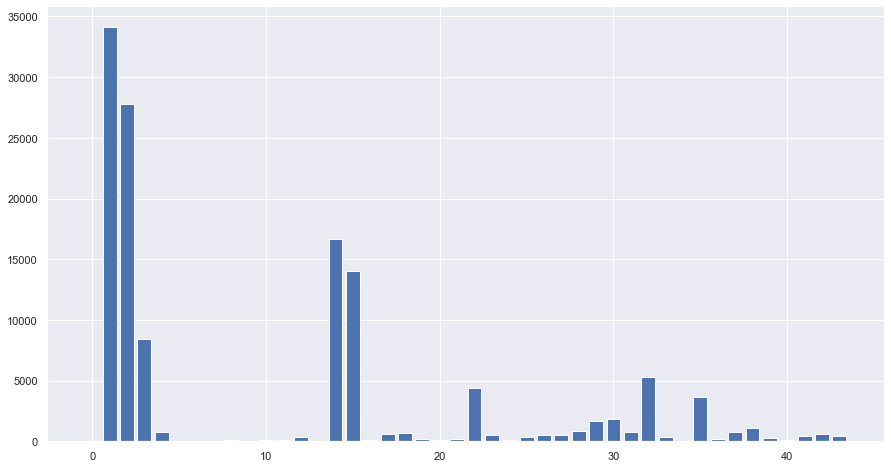

In [72]:
low_score_columns=[]

#Puntaje de cada feature
for i in fs.get_support(True):
    low_score_columns.append(df.columns[i])
    print('Feature',df.columns[i],' :', fs.scores_[i])
    
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()    

In [73]:
#Columnas utilizadas en los modelos

low_score_columns

['property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'cleaning_fee',
 'host_has_profile_pic',
 'host_identity_verified',
 'instant_bookable',
 'longitude',
 'number_of_reviews',
 'review_scores_rating',
 'zipcode',
 'bedrooms',
 'beds',
 'Wireless_Internet',
 'Kitchen',
 'Heating',
 'Essentials',
 'Smoke_detector',
 'Air_conditioning',
 'TV',
 'Shampoo',
 'Hangers',
 'Carbon_monoxide_detector',
 'Internet',
 'Laptop_friendly_workspace',
 'Hair_dryer',
 'Washer',
 'Dryer',
 'Iron',
 'Family_kid_friendly',
 'Fire_extinguisher',
 'Cable_TV',
 'Free_parking_on_premises',
 '24_hour_check_in',
 'Lock_on_bedroom_door',
 'Buzzer_wireless_intercom',
 'Safety_card',
 'Self_Check_In',
 'Elevator',
 'Pets_allowed']

## Descomentar la siguiente celda si se quiere entrenar los modelos con esta features 

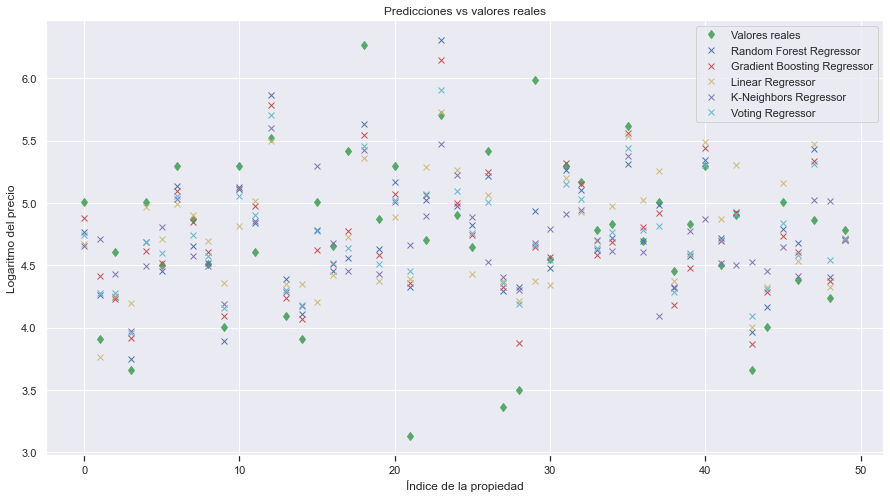

RF_R2 [0.697799207237585, 0.6990160329959274, 0.6990217933546203, 0.6982472908460362, 0.6979043900139128]
 
GB_R2 [0.6820624243121762, 0.6820918127392191, 0.6820624243121765, 0.6820624243121765, 0.682091812739219]
 
LR_R2 [0.5607587786503964, 0.5607587786503964, 0.5607587786503964, 0.5607587786503964, 0.5607587786503964]
 
KN_R2 [0.4772314654588925, 0.4772314654588925, 0.4772314654588925, 0.4772314654588925, 0.4772314654588925]
 
VR_R2 [0.6777166838119988, 0.6779219408414652, 0.6778740827228773, 0.6777532443860865, 0.6779827826706034]


In [74]:
X= df[low_score_columns]


RF_R2 = []
GB_R2 = []
LR_R2 = []
KN_R2 = []
VR_R2 = []

Mean_squared_errors = []



for i in range (5):

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    random_forest = RandomForestRegressor(n_estimators=100)
    random_forest.fit(X_train, y_train)
    rf_pred = random_forest.predict(X_test)
    rf_score = r2_score(y_test, rf_pred)
    rf_mse = mean_squared_error(y_test, rf_pred)
    #print(f"Random forest     : R2 {rf_score:.5f}  MSE {rf_mse:2.5f}")

    gradient_boosting = GradientBoostingRegressor(n_estimators=150)
    gradient_boosting.fit(X_train, y_train)
    gb_pred = gradient_boosting.predict(X_test)
    gb_score = r2_score(y_test, gb_pred)
    gb_mse = mean_squared_error(y_test, gb_pred)
    #print(f"Gradient boosting : R2 {gb_score:.5f}  MSE {gb_mse:2.5f}")

    linear_reg = LinearRegression(fit_intercept=True)
    linear_reg.fit(X_train, y_train)
    lr_pred = linear_reg.predict(X_test)
    lr_score = r2_score(y_test, lr_pred)
    lr_mse = mean_squared_error(y_test, lr_pred)
    #print(f"Linear regression : R2 {lr_score:.5f}  MSE {lr_mse:2.5f}")

    k_neighbors = KNeighborsRegressor(n_neighbors=30)
    k_neighbors.fit(X_train, y_train)
    kn_pred = k_neighbors.predict(X_test)
    kn_score = r2_score(y_test, kn_pred)
    kn_mse = mean_squared_error(y_test, kn_pred)
    #print(f"K Neighbors       : R2 {kn_score:.5f}  MSE {kn_mse:2.5f}")

    voting_reg = VotingRegressor(
        [("RF", random_forest), ("GB", gradient_boosting), ("KN", k_neighbors), ("LN", linear_reg)])
    voting_reg.fit(X_train, y_train)
    vr_pred = voting_reg.predict(X_test)
    vr_score = r2_score(y_test, vr_pred)
    vr_mse = mean_squared_error(y_test, vr_pred)
    #print(f"Voting regressor  : R2 {vr_score:.5f}  MSE {vr_mse:2.5f}")

    RF_R2.append(rf_score)
    GB_R2.append(gb_score)
    LR_R2.append(lr_score)
    KN_R2.append(kn_score)
    VR_R2.append(vr_score)


np.savetxt("Puntuaciones_RandomForestRegressor.csv", RF_R2, delimiter = ',')
np.savetxt("Puntuaciones_GradientBoostingRegressor.csv", GB_R2, delimiter = ',')
np.savetxt("Puntuaciones_LinearRegressor.csv", LR_R2, delimiter = ',')
np.savetxt("Puntuaciones_KNNRegressor.csv", KN_R2, delimiter = ',')
np.savetxt("Puntuaciones_VotingRegressor.csv", VR_R2, delimiter = ',')

rf_pred_col = rf_pred.reshape(-1, 1)
gb_pred_col = gb_pred.reshape(-1, 1)
kn_pred_col = kn_pred.reshape(-1, 1)
lr_pred_col = lr_pred.reshape(-1, 1)
vr_pred_col = vr_pred.reshape(-1, 1)
y_test_col = y_test.values.reshape(-1, 1)

plt.figure()
plt.plot(y_test_col[0:50, :], "gd", label="Valores reales")
plt.plot(rf_pred_col[0:50, :], "xb", label="Random Forest Regressor")
plt.plot(gb_pred_col[0:50, :], "xr", label="Gradient Boosting Regressor")
plt.plot(lr_pred_col[0:50, :], "xy", label="Linear Regressor")
plt.plot(kn_pred_col[0:50, :], "xm", label="K-Neighbors Regressor")
plt.plot(vr_pred_col[0:50, :], "xc", label="Voting Regressor")

plt.tick_params(axis='x', which="both", bottom=True,
                top=False, labelbottom=True)
plt.ylabel("Logaritmo del precio")
plt.xlabel("Índice de la propiedad")
plt.legend(loc="best")
plt.title("Predicciones vs valores reales")

plt.show()

"Dataset modificado con SelectPercentile"

print('RF_R2',RF_R2) 
print(' ')
print('GB_R2',GB_R2) 
print(' ')
print('LR_R2',LR_R2) 
print(' ') 
print('KN_R2',KN_R2) 
print(' ') 
print('VR_R2',VR_R2)





# Entrenamiento con el modelo de heatmap + f_regression

In [24]:
df_base =pd.read_csv('airbnb_clean.csv').set_index("id")
df_ammenities = pd.read_csv('airbnb_amenities_clean.csv').set_index("id")
df = pd.concat([df_base, df_ammenities], axis=1)

# Se quita host_sice ya que no es necesario para el modelo propuesto
Y = df['log_price']
df.drop(columns=["log_price", "host_since"], inplace=True)
#df.drop(columns=["log_price", 'host_since', 'host_has_profile_pic', 'longitude'], inplace=True)
bool_columns=df.select_dtypes(include = "bool").columns
string_columns=df.select_dtypes(include = "object").columns.tolist()

df[bool_columns]= df[bool_columns].replace({True: 1, False: 0})

#Se reemplazan los valores categoricos de string por valores numericos categoricos
#Se guardan las llaves y valores en dict_column_dict

dict_column_dict=[]
for column in string_columns:
    column_unique_value=df[column].unique().tolist()
    column_dictionary={column_unique_value[i]:i for i in range(0, len(column_unique_value))}
    dict_column_dict.append(column_dictionary)
    df[column]=df[column].replace(column_dictionary)

host_has_profile_pic
Wireless_Internet


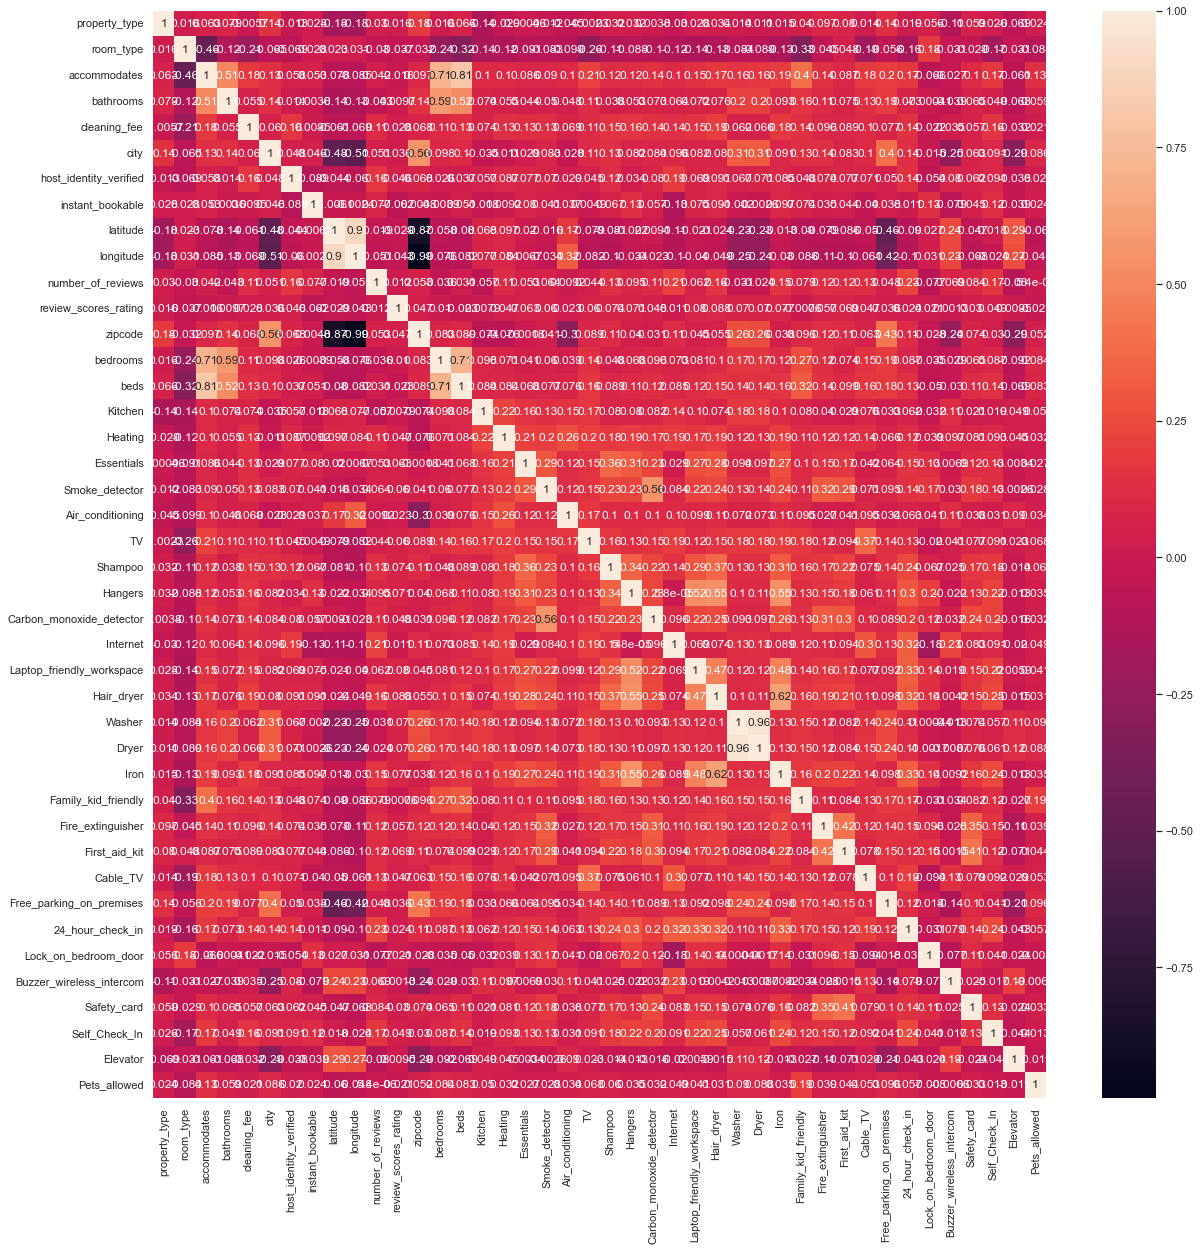

In [25]:
var_thr = VarianceThreshold(threshold = 0.05) #Removing both constant and quasi-constant
var_thr.fit(df)

concol = [column for column in df.columns 
          if column not in df.columns[var_thr.get_support()]]

for features in concol:
    print(features)

df.drop(columns=concol, inplace=True)


fig, ax = plt.subplots(figsize=(20, 20))
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()
df.drop(columns=["Washer", 'latitude'], inplace=True)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.2, random_state=1)

Feature room_type  : 34119.81565196113
Feature accommodates  : 27763.493997112735
Feature bathrooms  : 8419.012474465395
Feature cleaning_fee  : 729.6709593782779
Feature instant_bookable  : 118.74008037089284
Feature longitude  : 126.69313331692965
Feature number_of_reviews  : 67.31405139911686
Feature review_scores_rating  : 343.25427968849135
Feature zipcode  : 63.453596409362
Feature bedrooms  : 16706.40354202315
Feature beds  : 14039.176082686841
Feature Kitchen  : 618.322826913006
Feature Heating  : 665.5343083191409
Feature Essentials  : 180.1488991274177
Feature Smoke_detector  : 148.21702912708454
Feature Air_conditioning  : 185.64352311497152
Feature TV  : 4430.168203722186
Feature Shampoo  : 522.4631872084781
Feature Hangers  : 120.64958267579493
Feature Carbon_monoxide_detector  : 338.9654624318699
Feature Internet  : 532.1846786479076
Feature Laptop_friendly_workspace  : 520.5297293322772
Feature Hair_dryer  : 813.1495839257907
Feature Dryer  : 1804.62404756469
Feature Iro

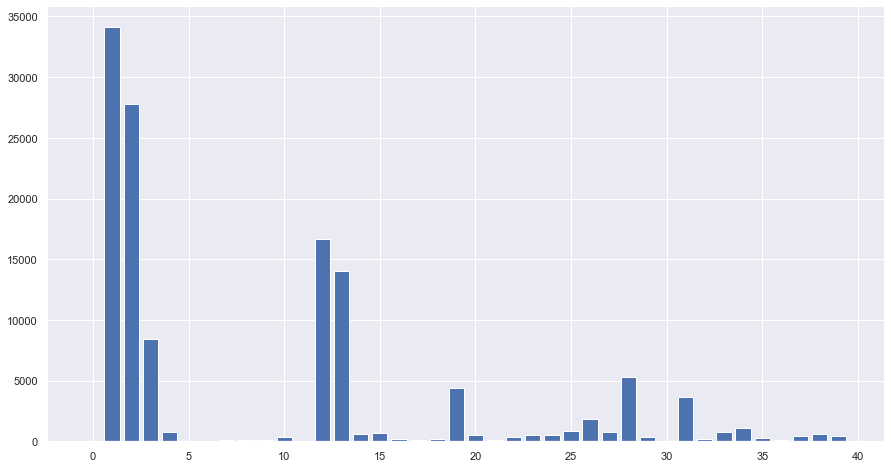

In [29]:
#Porcentaje de las features que se quiera conservar

porcentaje=90

# configure to select all features
fs = SelectPercentile(f_regression, percentile=porcentaje)
# learn relationship from training data
fs.fit(X_train, y_train)
# transform train input data
X_train = fs.transform(X_train)

low_score_columns=[]

#Puntaje de cada feature
for i in fs.get_support(True):
    low_score_columns.append(df.columns[i])
    print('Feature',df.columns[i],' :', fs.scores_[i])
    
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()  

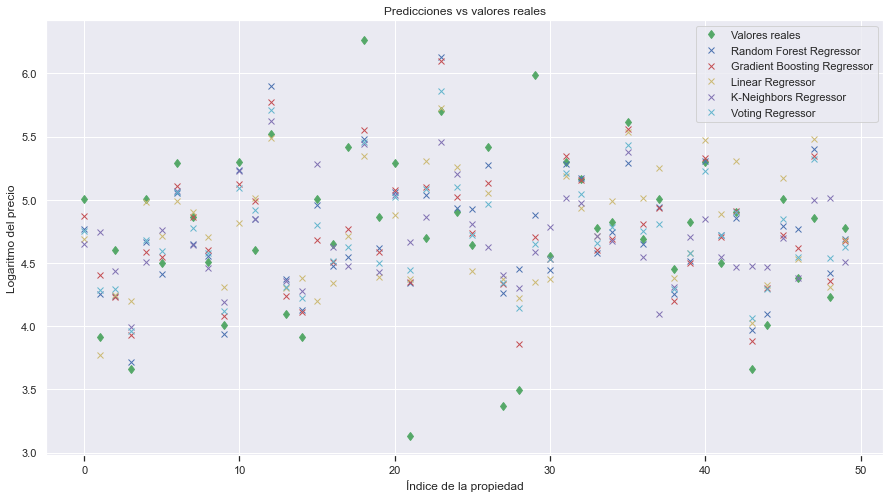

RF_R2 [0.6949325414974646, 0.6941055655468545, 0.695097796909907, 0.6949685727227591, 0.6955881197697033]
 
GB_R2 [0.6820758347651105, 0.6820758347651105, 0.6820758347651105, 0.6820758347651105, 0.6820758347651105]
 
LR_R2 [0.5592953992143437, 0.5592953992143437, 0.5592953992143437, 0.5592953992143437, 0.5592953992143437]
 
KN_R2 [0.4803995801832024, 0.4803995801832024, 0.4803995801832024, 0.4803995801832024, 0.4803995801832024]
 
VR_R2 [0.6767778135813515, 0.6767682484055979, 0.676963209613225, 0.6767788131901898, 0.6768052420931979]


In [30]:

X= df[low_score_columns]


RF_R2 = []
GB_R2 = []
LR_R2 = []
KN_R2 = []
VR_R2 = []

Mean_squared_errors = []



for i in range (5):

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    random_forest = RandomForestRegressor(n_estimators=100)
    random_forest.fit(X_train, y_train)
    rf_pred = random_forest.predict(X_test)
    rf_score = r2_score(y_test, rf_pred)
    rf_mse = mean_squared_error(y_test, rf_pred)
    #print(f"Random forest     : R2 {rf_score:.5f}  MSE {rf_mse:2.5f}")

    gradient_boosting = GradientBoostingRegressor(n_estimators=150)
    gradient_boosting.fit(X_train, y_train)
    gb_pred = gradient_boosting.predict(X_test)
    gb_score = r2_score(y_test, gb_pred)
    gb_mse = mean_squared_error(y_test, gb_pred)
    #print(f"Gradient boosting : R2 {gb_score:.5f}  MSE {gb_mse:2.5f}")

    linear_reg = LinearRegression(fit_intercept=True)
    linear_reg.fit(X_train, y_train)
    lr_pred = linear_reg.predict(X_test)
    lr_score = r2_score(y_test, lr_pred)
    lr_mse = mean_squared_error(y_test, lr_pred)
    #print(f"Linear regression : R2 {lr_score:.5f}  MSE {lr_mse:2.5f}")

    k_neighbors = KNeighborsRegressor(n_neighbors=30)
    k_neighbors.fit(X_train, y_train)
    kn_pred = k_neighbors.predict(X_test)
    kn_score = r2_score(y_test, kn_pred)
    kn_mse = mean_squared_error(y_test, kn_pred)
    #print(f"K Neighbors       : R2 {kn_score:.5f}  MSE {kn_mse:2.5f}")

    voting_reg = VotingRegressor(
        [("RF", random_forest), ("GB", gradient_boosting), ("KN", k_neighbors), ("LN", linear_reg)])
    voting_reg.fit(X_train, y_train)
    vr_pred = voting_reg.predict(X_test)
    vr_score = r2_score(y_test, vr_pred)
    vr_mse = mean_squared_error(y_test, vr_pred)
    #print(f"Voting regressor  : R2 {vr_score:.5f}  MSE {vr_mse:2.5f}")

    RF_R2.append(rf_score)
    GB_R2.append(gb_score)
    LR_R2.append(lr_score)
    KN_R2.append(kn_score)
    VR_R2.append(vr_score)


np.savetxt("Puntuaciones_RandomForestRegressor.csv", RF_R2, delimiter = ',')
np.savetxt("Puntuaciones_GradientBoostingRegressor.csv", GB_R2, delimiter = ',')
np.savetxt("Puntuaciones_LinearRegressor.csv", LR_R2, delimiter = ',')
np.savetxt("Puntuaciones_KNNRegressor.csv", KN_R2, delimiter = ',')
np.savetxt("Puntuaciones_VotingRegressor.csv", VR_R2, delimiter = ',')

rf_pred_col = rf_pred.reshape(-1, 1)
gb_pred_col = gb_pred.reshape(-1, 1)
kn_pred_col = kn_pred.reshape(-1, 1)
lr_pred_col = lr_pred.reshape(-1, 1)
vr_pred_col = vr_pred.reshape(-1, 1)
y_test_col = y_test.values.reshape(-1, 1)

plt.figure()
plt.plot(y_test_col[0:50, :], "gd", label="Valores reales")
plt.plot(rf_pred_col[0:50, :], "xb", label="Random Forest Regressor")
plt.plot(gb_pred_col[0:50, :], "xr", label="Gradient Boosting Regressor")
plt.plot(lr_pred_col[0:50, :], "xy", label="Linear Regressor")
plt.plot(kn_pred_col[0:50, :], "xm", label="K-Neighbors Regressor")
plt.plot(vr_pred_col[0:50, :], "xc", label="Voting Regressor")

plt.tick_params(axis='x', which="both", bottom=True,
                top=False, labelbottom=True)
plt.ylabel("Logaritmo del precio")
plt.xlabel("Índice de la propiedad")
plt.legend(loc="best")
plt.title("Predicciones vs valores reales")

plt.show()

"Dataset modificado con SelectPercentile"

print('RF_R2',RF_R2) 
print(' ')
print('GB_R2',GB_R2) 
print(' ')
print('LR_R2',LR_R2) 
print(' ') 
print('KN_R2',KN_R2) 
print(' ') 
print('VR_R2',VR_R2)


# Entrenamiento con el modelo que se tenía en el avance 

In [31]:
df_base = pd.read_csv('airbnb_clean.csv').set_index("id")
df_ammenities = pd.read_csv('airbnb_amenities_clean.csv').set_index("id")
df = pd.concat([df_base, df_ammenities], axis=1)


bool_columns=df.select_dtypes(include = "bool").columns
string_columns=df.select_dtypes(include = "object").columns.tolist()

df[bool_columns]= df[bool_columns].replace({True: 1, False: 0})

#Se reemplazan los valores categoricos de string por valores numericos categoricos
#Se guardan las llaves y valores en dict_column_dict

dict_column_dict=[]
for column in string_columns:
    column_unique_value=df[column].unique().tolist()
    column_dictionary={column_unique_value[i]:i for i in range(0, len(column_unique_value))}
    dict_column_dict.append(column_dictionary)
    df[column]=df[column].replace(column_dictionary)



X = df.drop(columns=["log_price", "host_since", "host_has_profile_pic", "city",
                     "host_identity_verified", "property_type", "room_type"])
Y = df['log_price']



In [32]:
X.columns

Index(['accommodates', 'bathrooms', 'cleaning_fee', 'instant_bookable',
       'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating',
       'zipcode', 'bedrooms', 'beds', 'Wireless_Internet', 'Kitchen',
       'Heating', 'Essentials', 'Smoke_detector', 'Air_conditioning', 'TV',
       'Shampoo', 'Hangers', 'Carbon_monoxide_detector', 'Internet',
       'Laptop_friendly_workspace', 'Hair_dryer', 'Washer', 'Dryer', 'Iron',
       'Family_kid_friendly', 'Fire_extinguisher', 'First_aid_kit', 'Cable_TV',
       'Free_parking_on_premises', '24_hour_check_in', 'Lock_on_bedroom_door',
       'Buzzer_wireless_intercom', 'Safety_card', 'Self_Check_In', 'Elevator',
       'Pets_allowed'],
      dtype='object')

## Descomentar la siguiente celda si se quiere entrenar los modelos con las features que se tenian en el avance

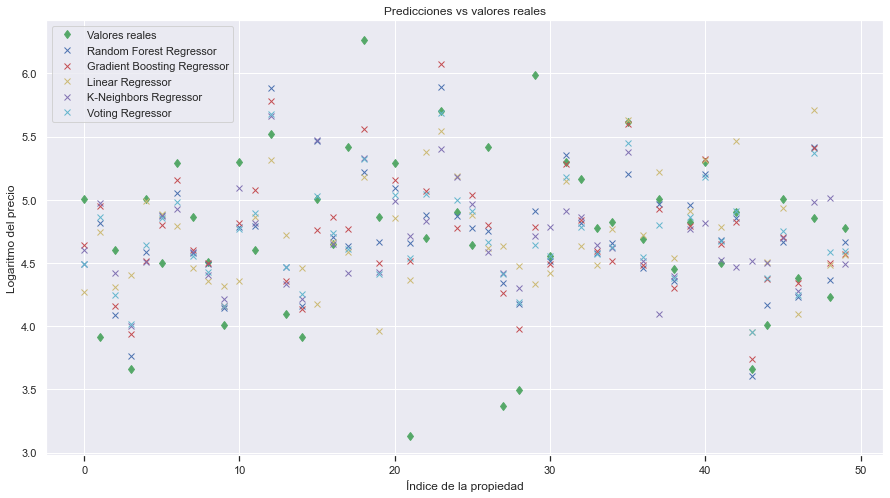

RF_R2 [0.6632507585820071, 0.6626651745352332, 0.6627280203859427, 0.6608092441676751, 0.6624023214279237]
 
GB_R2 [0.6375360508411563, 0.6375530651515586, 0.6375240917223974, 0.6375530651515586, 0.63753335846149]
 
LR_R2 [0.4415692627593337, 0.4415692627593337, 0.4415692627593337, 0.4415692627593337, 0.4415692627593337]
 
KN_R2 [0.46267320104694576, 0.46267320104694576, 0.46267320104694576, 0.46267320104694576, 0.46267320104694576]
 
VR_R2 [0.6265832661548729, 0.6264049300277407, 0.6261243673394273, 0.6261718621760546, 0.6266113009304921]


In [33]:

RF_R2 = []
GB_R2 = []
LR_R2 = []
KN_R2 = []
VR_R2 = []

Mean_squared_errors = []



for i in range (5):

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    random_forest = RandomForestRegressor(n_estimators=100)
    random_forest.fit(X_train, y_train)
    rf_pred = random_forest.predict(X_test)
    rf_score = r2_score(y_test, rf_pred)
    rf_mse = mean_squared_error(y_test, rf_pred)
    #print(f"Random forest     : R2 {rf_score:.5f}  MSE {rf_mse:2.5f}")

    gradient_boosting = GradientBoostingRegressor(n_estimators=150)
    gradient_boosting.fit(X_train, y_train)
    gb_pred = gradient_boosting.predict(X_test)
    gb_score = r2_score(y_test, gb_pred)
    gb_mse = mean_squared_error(y_test, gb_pred)
    #print(f"Gradient boosting : R2 {gb_score:.5f}  MSE {gb_mse:2.5f}")

    linear_reg = LinearRegression(fit_intercept=True)
    linear_reg.fit(X_train, y_train)
    lr_pred = linear_reg.predict(X_test)
    lr_score = r2_score(y_test, lr_pred)
    lr_mse = mean_squared_error(y_test, lr_pred)
    #print(f"Linear regression : R2 {lr_score:.5f}  MSE {lr_mse:2.5f}")

    k_neighbors = KNeighborsRegressor(n_neighbors=30)
    k_neighbors.fit(X_train, y_train)
    kn_pred = k_neighbors.predict(X_test)
    kn_score = r2_score(y_test, kn_pred)
    kn_mse = mean_squared_error(y_test, kn_pred)
    #print(f"K Neighbors       : R2 {kn_score:.5f}  MSE {kn_mse:2.5f}")

    voting_reg = VotingRegressor(
        [("RF", random_forest), ("GB", gradient_boosting), ("KN", k_neighbors), ("LN", linear_reg)])
    voting_reg.fit(X_train, y_train)
    vr_pred = voting_reg.predict(X_test)
    vr_score = r2_score(y_test, vr_pred)
    vr_mse = mean_squared_error(y_test, vr_pred)
    #print(f"Voting regressor  : R2 {vr_score:.5f}  MSE {vr_mse:2.5f}")

    RF_R2.append(rf_score)
    GB_R2.append(gb_score)
    LR_R2.append(lr_score)
    KN_R2.append(kn_score)
    VR_R2.append(vr_score)


np.savetxt("Puntuaciones_RandomForestRegressor.csv", RF_R2, delimiter = ',')
np.savetxt("Puntuaciones_GradientBoostingRegressor.csv", GB_R2, delimiter = ',')
np.savetxt("Puntuaciones_LinearRegressor.csv", LR_R2, delimiter = ',')
np.savetxt("Puntuaciones_KNNRegressor.csv", KN_R2, delimiter = ',')
np.savetxt("Puntuaciones_VotingRegressor.csv", VR_R2, delimiter = ',')

rf_pred_col = rf_pred.reshape(-1, 1)
gb_pred_col = gb_pred.reshape(-1, 1)
kn_pred_col = kn_pred.reshape(-1, 1)
lr_pred_col = lr_pred.reshape(-1, 1)
vr_pred_col = vr_pred.reshape(-1, 1)
y_test_col = y_test.values.reshape(-1, 1)

plt.figure()
plt.plot(y_test_col[0:50, :], "gd", label="Valores reales")
plt.plot(rf_pred_col[0:50, :], "xb", label="Random Forest Regressor")
plt.plot(gb_pred_col[0:50, :], "xr", label="Gradient Boosting Regressor")
plt.plot(lr_pred_col[0:50, :], "xy", label="Linear Regressor")
plt.plot(kn_pred_col[0:50, :], "xm", label="K-Neighbors Regressor")
plt.plot(vr_pred_col[0:50, :], "xc", label="Voting Regressor")

plt.tick_params(axis='x', which="both", bottom=True,
                top=False, labelbottom=True)
plt.ylabel("Logaritmo del precio")
plt.xlabel("Índice de la propiedad")
plt.legend(loc="best")
plt.title("Predicciones vs valores reales")

plt.show()

"Dataset con las features del avance pasado"

print('RF_R2',RF_R2) 
print(' ')
print('GB_R2',GB_R2) 
print(' ')
print('LR_R2',LR_R2) 
print(' ') 
print('KN_R2',KN_R2) 
print(' ') 
print('VR_R2',VR_R2)



# Usando LabelEncoder

In [76]:
df_base = pd.read_csv('airbnb_clean.csv').set_index("id")
df_ammenities = pd.read_csv('airbnb_amenities_clean.csv').set_index("id")
df = pd.concat([df_base, df_ammenities], axis=1)



In [ ]:
categorical_col=[]
df.unique.tolist()


In [ ]:
bool_columns=df.select_dtypes(include = "bool").columns
string_columns=df.select_dtypes(include = "object").columns.tolist()

df[bool_columns]= df[bool_columns].replace({True: 1, False: 0})

#Se reemplazan los valores categoricos de string por valores numericos categoricos
#Se guardan las llaves y valores en dict_column_dict

dict_column_dict=[]
for column in string_columns:
    column_unique_value=df[column].unique().tolist()
    column_dictionary={column_unique_value[i]:i for i in range(0, len(column_unique_value))}
    dict_column_dict.append(column_dictionary)
    df[column]=df[column].replace(column_dictionary)